In [1]:
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action="ignore")
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier,RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import eli5
import pickle
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

### Loading Data 

In [3]:
request = pd.read_csv("data/requests.csv")
device = pd.read_csv("data/device_info.csv")
data = request.merge(device,how="left",on="accountid")

In [4]:
data['anomaly_feat_0'] = data['anomaly_feat_0'].astype('bool')
data['anomaly_feat_1'] = data['anomaly_feat_1'].astype('bool')
data['anomaly_feat_2'] = data['anomaly_feat_2'].astype('bool')
data['interaction_feat_0'] = data['interaction_feat_0'].astype('bool')

### Exploratory Data Analysis 

In [5]:
summary = data.describe(include='all')
summary

,anomaly_feat_0,anomaly_feat_1,anomaly_feat_2,anomaly_feat_3,count_feat_0,count_feat_1,count_feat_2,count_feat_3,count_feat_4,count_feat_5,...,count_feat_17,interaction_feat_0,interaction_feat_1,interaction_feat_2,interaction_feat_3,timestamp,is_attack,accountid,device_feat_1,device_feat_2
count,30012,30012,30012,30012,30008.000000,30008.000000,29987.000000,30006.000000,29987.000000,30000.000000,...,11.000000,30012,30012,29993.000000,29993.000000,30012.000000,30012,30012,20923,20923
unique,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,2,NaN,NaN,NaN,2,27616,24,4480
top,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,False,NaN,NaN,NaN,False,02ce927a-7c49-4de2-8088-fdbe60162cdf,browser_16,device_5428
freq,25416,27855,28133,27222,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23666,23666,NaN,NaN,NaN,27090,165,11469,2120
mean,NaN,NaN,NaN,NaN,6.813117,0.612870,0.065414,6.840032,0.182279,38.217333,...,0.272727,NaN,NaN,0.803588,0.134498,14756.859390,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,45.279530,1.859637,1.862368,44.650378,1.565971,260.955819,...,0.646670,NaN,NaN,4.040605,0.600453,8507.031268,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,NaN,0.000000,0.000000,7385.750000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,NaN,0.000000,0.000000,14761.500000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,...,0.000000,NaN,NaN,0.000000,0.000000,22130.250000,NaN,NaN,NaN,NaN


### Key findings:
1. "anomaly_feat_3" is having higher corelation with “is_attack” target variable.
2. "anomoly_feat_0", "anomoly_feat_1", and "anomoly_feat_2" are correlated with each other, if linear model is used correlation might sabotage the final outputs.
3. The “account_id” and time feature are bad predictor for the model, as they are mostly unique for all the transactions.

In [6]:
data.corr('spearman').style.background_gradient()

,anomaly_feat_0,anomaly_feat_1,anomaly_feat_2,anomaly_feat_3,count_feat_0,count_feat_1,count_feat_2,count_feat_3,count_feat_4,count_feat_5,count_feat_6,count_feat_7,count_feat_8,count_feat_9,count_feat_10,count_feat_11,count_feat_12,count_feat_13,count_feat_14,count_feat_15,count_feat_16,count_feat_17,interaction_feat_0,interaction_feat_1,interaction_feat_2,interaction_feat_3,timestamp,is_attack
anomaly_feat_0,1.000000,0.562681,0.593228,-0.093441,-0.053654,0.098222,-0.024049,0.028680,-0.019555,-0.239419,0.020945,0.050077,0.073877,0.243168,0.401157,0.206245,0.057549,0.017075,0.077250,-0.022156,0.620484,0.088641,0.189614,-0.189614,-0.029312,0.001863,0.204972,0.153411
anomaly_feat_1,0.562681,1.000000,0.906347,-0.074870,-0.015198,0.082208,-0.053762,0.085434,-0.048718,-0.186827,0.025834,0.070100,0.114733,0.014474,0.046143,-0.055562,0.068364,-0.039224,-0.029637,-0.051498,0.994987,0.331662,0.118824,-0.118824,-0.065505,-0.042996,0.299893,0.289394
anomaly_feat_2,0.593228,0.906347,1.000000,-0.075158,-0.028297,0.053310,-0.064968,0.056854,-0.063087,-0.200186,0.038482,0.083569,0.087608,0.020366,0.053257,-0.059314,0.039134,-0.041034,-0.034451,-0.063948,0.994987,0.331662,0.128437,-0.128437,-0.105547,-0.078572,0.320232,0.271443
anomaly_feat_3,-0.093441,-0.074870,-0.075158,1.000000,-0.043991,-0.097703,0.263921,-0.091202,0.176456,-0.042942,-0.079654,-0.071302,-0.058971,0.211139,0.212168,0.122507,-0.107266,0.342631,0.299797,0.199990,nan,nan,-0.617112,0.617112,-0.133131,-0.098526,-0.002444,0.401918
count_feat_0,-0.053654,-0.015198,-0.028297,-0.043991,1.000000,0.038590,0.020925,0.443959,-0.028411,0.153977,-0.048353,-0.087889,0.529799,0.043480,0.217643,0.347502,0.565975,-0.028353,-0.022841,-0.031427,-0.220000,-0.220000,0.092112,-0.092112,-0.038688,-0.020423,0.005155,-0.010597
count_feat_1,0.098222,0.082208,0.053310,-0.097703,0.038590,1.000000,0.304505,0.554763,0.341680,-0.055335,-0.004114,0.003824,0.698754,0.328157,0.093690,0.430085,0.796704,0.084730,0.012119,0.329416,0.475708,-0.074329,-0.015681,0.015681,0.067879,0.021829,-0.020425,0.108973
count_feat_2,-0.024049,-0.053762,-0.064968,0.263921,0.020925,0.304505,1.000000,0.275799,0.940223,0.021932,-0.011266,-0.004323,0.239316,0.135513,0.121754,0.324860,0.262424,0.584357,0.498642,0.921549,nan,nan,-0.363823,0.363823,0.030218,0.051947,-0.043165,0.206203
count_feat_3,0.028680,0.085434,0.056854,-0.091202,0.443959,0.554763,0.275799,1.000000,0.301032,0.075396,-0.051600,-0.077358,0.664807,0.113568,0.231254,0.449646,0.734396,0.017398,0.001407,0.287773,0.499745,-0.214176,-0.053419,0.053419,-0.038750,-0.027744,0.022244,0.128563
count_feat_4,-0.019555,-0.048718,-0.063087,0.176456,-0.028411,0.341680,0.940223,0.301032,1.000000,0.024461,-0.005057,0.002510,0.236675,0.119229,0.105990,0.336572,0.262525,0.564340,0.456285,0.967756,nan,nan,-0.329181,0.329181,0.044385,0.062360,-0.051699,0.179930
count_feat_5,-0.239419,-0.186827,-0.200186,-0.042942,0.153977,-0.055335,0.021932,0.075396,0.024461,1.000000,0.052841,0.026499,0.078632,-0.128435,-0.096125,-0.033021,0.032399,-0.065464,-0.071101,0.017350,-0.244047,-0.366070,-0.077317,0.077317,-0.113154,-0.086633,-0.059564,-0.093562


### Data Preparation

In [7]:
X = data.drop(columns=['is_attack'])
y = data['is_attack']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [8]:
y_train.value_counts(normalize=True)

False    0.904275
True     0.095725
Name: is_attack, dtype: float64

In [9]:
numeric_features = ['count_feat_0', 'count_feat_1', 'count_feat_2', 'count_feat_3',
       'count_feat_4', 'count_feat_5', 'count_feat_6', 'count_feat_7',
       'count_feat_8', 'count_feat_9', 'count_feat_10', 'count_feat_11',
       'count_feat_12', 'count_feat_13', 'count_feat_14', 'count_feat_15',
       'count_feat_16', 'count_feat_17', 'interaction_feat_2', 'interaction_feat_3']
categorical_features = ['device_feat_1', 'device_feat_2']
binary_features = ['anomaly_feat_0', 'anomaly_feat_1', 'anomaly_feat_2', 'anomaly_feat_3', 'interaction_feat_0', 'interaction_feat_1']
drop_features = ['timestamp', 'accountid']

### Making pipeline to take care of the Golden Rule

In [10]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary", dtype=bool),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [11]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['count_feat_0', 'count_feat_1',
                                  'count_feat_2', 'count_feat_3',
                                  'count_feat_4', 'count_feat_5',
                                  'count_feat_6', 'count_feat_7',
                                  'count_feat_8', 'count_feat_9',
                                  'count_feat_10', 'count_feat_11',
                                  'count_feat_12', 'count_feat_13',
                                  '...
                                 ['anomaly_feat_0', 'anomaly_feat_1',
                                  'anomaly_feat_2', 'anomaly_feat_3',
                                  'interaction_feat_0', 'interaction_feat_1']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['device_feat_1', 'device_feat_2']),
                                ('drop', 'drop', ['timestamp', 'accountid'])])

In [12]:
scoring_metric = "f1"
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)

In [13]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(class_weight="balanced", random_state=123)
)
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        random_state=123, verbosity=0
    ),
)
pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123)
)

pipe_catboost = make_pipeline(
    preprocessor,
    CatBoostClassifier(verbose=0, random_state=123),
)

pipe_sklearn_histGB = make_pipeline(
    preprocessor,
    HistGradientBoostingClassifier(random_state=123),
)

pipe_sklearn_GB = make_pipeline(
    preprocessor,
    GradientBoostingClassifier(random_state=123),
)

classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

In [14]:
dummy = DummyClassifier()
results = {}
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)

In [15]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
    )

[LightGBM] [Info] Number of positive: 1609, number of negative: 15197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 16806, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095740 -> initscore=-2.245485
[LightGBM] [Info] Start training from score -2.245485
[LightGBM] [Info] Number of positive: 1609, number of negative: 15197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 16806, number of used features: 97
[LightGBM] [Info] [b

### Scores of all the Models that I have tried

    - We can see that the XG boost has the highest F1 score compared to other models
    - We can use Accuracy here, it is not a great measure for an unbalaced dataset

In [16]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,11.743 (+/- 1.689),0.130 (+/- 0.007),0.656 (+/- 0.017),0.663 (+/- 0.006)
decision tree,8.275 (+/- 1.187),0.133 (+/- 0.008),0.723 (+/- 0.009),0.999 (+/- 0.000)
random forest,21.166 (+/- 0.942),0.280 (+/- 0.016),0.698 (+/- 0.014),0.999 (+/- 0.001)
XGBoost,2.837 (+/- 0.145),0.131 (+/- 0.002),0.777 (+/- 0.012),0.926 (+/- 0.003)
LightGBM,0.804 (+/- 0.206),0.141 (+/- 0.003),0.771 (+/- 0.014),0.885 (+/- 0.008)
CatBoost,30.675 (+/- 4.187),2.595 (+/- 0.107),0.750 (+/- 0.017),0.822 (+/- 0.003)
sklearn_histGB,41.107 (+/- 5.934),0.125 (+/- 0.006),0.764 (+/- 0.013),0.860 (+/- 0.014)
sklearn_GB,204.497 (+/- 19.435),0.147 (+/- 0.019),0.719 (+/- 0.014),0.744 (+/- 0.004)


In [17]:
del classifiers["sklearn_histGB"]
del classifiers["sklearn_GB"]
del classifiers["CatBoost"]
del classifiers["random forest"]
del classifiers["logistic regression"]
del classifiers["decision tree"]

### Voting Classifier
    - As LightGBM and XGBoost are best model with close scores, here I am checking to see if Voting of 2 Models can make a final model better.

In [18]:

averaging_model = VotingClassifier(
    list(classifiers.items()), voting="soft"
) 

In [19]:
from sklearn import set_config
set_config(display="diagram")

In [20]:
averaging_model

VotingClassifier(estimators=[('XGBoost',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer()),
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['count_feat_0',
                                                                                 'count_feat_1',
                                                                                 'count_feat_2',
                                                                                 'count_feat_3',
                                                                                 'count_feat_4',
                                                                                 'count_feat_5',
                                                                                 'count_feat_6',
                                                                                 'count_feat_7',
                                                                                 'count_feat_8',
                                                                                 'co...
                                                                                 'interaction_feat_0',
                                                                                 'interaction_feat_1']),
                                                                               ('pipeline-3',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(fill_value='missing',
                                                                                                               strategy='constant')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['device_feat_1',
                                                                                 'device_feat_2']),
                                                                               ('drop',
                                                                                'drop',
                                                                                ['timestamp',
                                                                                 'accountid'])])),
                                              ('lgbmclassifier',
                                               LGBMClassifier(random_state=123))]))],
                 voting='soft')

In [21]:
results["Voting"] = mean_std_cross_val_scores(
    averaging_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

[LightGBM] [Info] Number of positive: 1609, number of negative: 15197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 16806, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095740 -> initscore=-2.245485
[LightGBM] [Info] Start training from score -2.245485
[LightGBM] [Info] Number of positive: 1609, number of negative: 15197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 16806, number of used features: 97
[LightGBM] [Info] [b

,fit_time,score_time,test_score,train_score
Dummy,0.003 (+/- 0.001),0.002 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,11.743 (+/- 1.689),0.130 (+/- 0.007),0.656 (+/- 0.017),0.663 (+/- 0.006)
decision tree,8.275 (+/- 1.187),0.133 (+/- 0.008),0.723 (+/- 0.009),0.999 (+/- 0.000)
random forest,21.166 (+/- 0.942),0.280 (+/- 0.016),0.698 (+/- 0.014),0.999 (+/- 0.001)
XGBoost,2.837 (+/- 0.145),0.131 (+/- 0.002),0.777 (+/- 0.012),0.926 (+/- 0.003)
LightGBM,0.804 (+/- 0.206),0.141 (+/- 0.003),0.771 (+/- 0.014),0.885 (+/- 0.008)
CatBoost,30.675 (+/- 4.187),2.595 (+/- 0.107),0.750 (+/- 0.017),0.822 (+/- 0.003)
sklearn_histGB,41.107 (+/- 5.934),0.125 (+/- 0.006),0.764 (+/- 0.013),0.860 (+/- 0.014)
sklearn_GB,204.497 (+/- 19.435),0.147 (+/- 0.019),0.719 (+/- 0.014),0.744 (+/- 0.004)
Voting,5.140 (+/- 0.266),0.317 (+/- 0.043),0.778 (+/- 0.015),0.910 (+/- 0.003)


- We can see that Voting classifier is not doing better than XGboost. We are going ahead with XGboost Model from here.

In [22]:
pipe_xgb_vis = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_xgb_vis.fit(X_train, y_train_num)

feature_names = (
    numeric_features
    + binary_features
    + pipe_xgb_vis.named_steps["columntransformer"]
    .named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
eli5.explain_weights(pipe_xgb_vis.named_steps["xgbclassifier"], feature_names=feature_names)

Weight,Feature
0.2530,anomaly_feat_3
0.1665,anomaly_feat_2
0.0851,count_feat_0
0.0815,anomaly_feat_1
0.0538,count_feat_8
0.0435,device_feat_1_browser_11
0.0356,interaction_feat_0
0.0254,device_feat_2_device_4657
0.0183,count_feat_6
0.0163,count_feat_11


(0.9233673901401847, 0.8533240703604353, 0.8842866360361894, None)

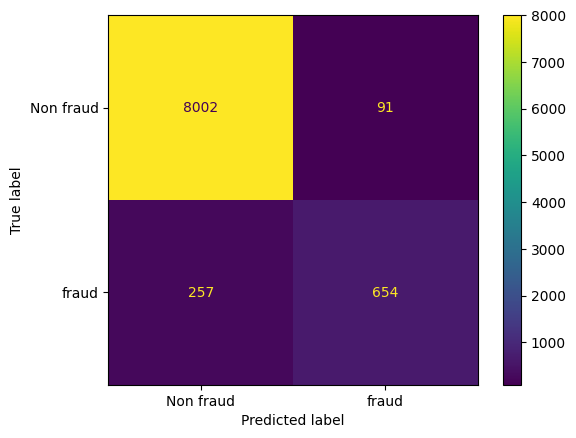

In [23]:
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_xgb_vis, X_test, y_test, values_format="d", display_labels=["Non fraud","fraud"]
)
y_pred=pipe_xgb_vis.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

# Trying out the hyperparameter tuning for few top parameters in XGBoost

In [24]:
param_grid = {
        'xgbclassifier__min_child_weight': [1, 5, 10],
        'xgbclassifier__gamma': [0.5, 1, 1.5, 2, 5],
        'xgbclassifier__subsample': [0.6, 0.8, 1.0],
        'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
        'xgbclassifier__max_depth': [3, 4, 5]
        }
rand_search = RandomizedSearchCV(
    pipe_xgb, param_distributions=param_grid, cv=5,  n_jobs=-1, n_iter=20, random_state=42,verbose=3,scoring='f1'
)

In [25]:
start = time.time()
rand_search.fit(X_train, y_train) # all the work is done here
end = time.time()
print(end - start)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
186.94062161445618


#### We are seeing a very slight improvement in the score compared to before ~96% -> ~97 % which is not very good
    - If we have to use the hyperparameter it will overfit the data, hence going ahead with default values are better for practical data.

In [26]:
pd.DataFrame(rand_search.cv_results_)[
    [
        "mean_test_score",
        "param_xgbclassifier__subsample",
        "param_xgbclassifier__min_child_weight",
        "param_xgbclassifier__max_depth",
        'param_xgbclassifier__gamma',
       'param_xgbclassifier__colsample_bytree',
        "mean_fit_time",
        "rank_test_score",
    ]].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.76771,0.764746,0.761037,0.754417,0.752327,0.748657,0.743022,0.742657,0.741573,0.740497,0.739412,0.736958,0.735604,0.734393,0.733065,0.732169,0.728881,0.727274,0.724571,0.714402
param_xgbclassifier__subsample,1.0,0.6,0.8,1.0,0.8,0.8,0.6,1.0,0.8,0.8,0.6,1.0,0.6,0.6,0.6,0.6,1.0,1.0,0.6,0.8
param_xgbclassifier__min_child_weight,1,1,5,1,1,5,10,5,5,10,1,5,10,10,10,10,1,10,5,10
param_xgbclassifier__max_depth,5,4,4,3,3,4,4,5,5,4,4,4,4,5,3,3,3,3,4,3
param_xgbclassifier__gamma,0.5,0.5,0.5,0.5,2,2,1,1.5,5,1.5,5,2,1,1.5,1.5,1,2,1.5,5,5
param_xgbclassifier__colsample_bytree,0.8,0.6,1.0,0.8,1.0,1.0,0.6,0.6,0.8,0.6,1.0,1.0,0.8,0.6,0.8,0.6,0.8,1.0,0.8,1.0
mean_fit_time,19.476239,21.084269,22.088094,19.968608,19.346953,20.236983,22.165259,18.750285,18.143899,23.498828,18.039406,18.303234,21.565091,23.319437,17.338616,20.90057,20.929525,17.918639,19.778552,19.392744


In [27]:
rand_search.best_score_

0.7677104110762277

In [28]:
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0,min_child_weight=1,max_depth=5,gamma=.5,colsample_bytree=.8,subsample=1)
)
pipe_xgb.fit(X_train, y_train_num)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['count_feat_0',
                                                   'count_feat_1',
                                                   'count_feat_2',
                                                   'count_feat_3',
                                                   'count_feat_4',
                                                   'count_feat_5',
                                                   'count_feat_6',
                                                   'count_feat_7',
                                                   'count_feat_8',
                                                   'count_feat_9',
                                                   'count_feat_10',
                                                   'count_feat_...
                               feature_types=None, gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=123, ...))])

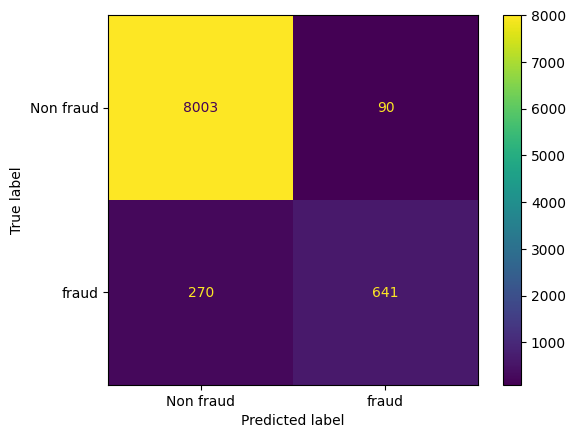

In [29]:
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_xgb, X_test, y_test, values_format="d", display_labels=["Non fraud","fraud"]
)
y_pred_best=pipe_xgb.predict(X_test)

In [30]:
# As we have to find the best tradeoff between precision and recall lets try to change the threshold
pd.DataFrame(pipe_xgb_vis.predict_proba(X_test)).head()

,0,1
0,0.999748,0.000252
1,0.597168,0.402832
2,0.999795,0.000205
3,0.191252,0.808748
4,0.998315,0.001685


In [31]:
prob_scores = pipe_xgb_vis.predict_proba(X_test)
threshold = 0.5  # Set your desired threshold value

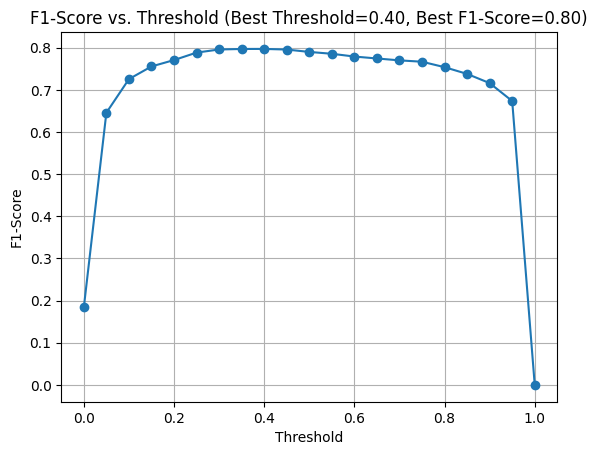

The best threshold is 0.40 with an F1-score of 0.80


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
thresholds = np.arange(0, 1.05, 0.05)
best_threshold = 0
best_f1 = 0
f1_scores = []
precision_values = []
recall_values = []
for threshold in thresholds:
    final_predictions = [1 if prob_score[1] >= threshold else 0 for prob_score in prob_scores]
    f1 = f1_score(y_test, final_predictions)
    f1_scores.append(f1)
    precision = precision_score(y_test, final_predictions)
    recall = recall_score(y_test, final_predictions)
    precision_values.append(final_predictions)
    recall_values.append(recall)
    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1
plt.figure()
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title(f'F1-Score vs. Threshold (Best Threshold={best_threshold:.2f}, Best F1-Score={best_f1:.2f})')
plt.grid()
plt.show()
print(f"The best threshold is {best_threshold:.2f} with an F1-score of {best_f1:.2f}")

In [33]:
from sklearn.metrics import classification_report
print('threshold at 0.5\n')
print(classification_report(y_test, y_pred_best))
print('\n==========================================================')
print('\nthreshold at 0.4')
y_pred_lower_threshold = pipe_xgb_vis.predict_proba(X_test)[:, 1] > 0.4
print(classification_report(y_test, y_pred_lower_threshold))

threshold at 0.5

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      8093
        True       0.88      0.70      0.78       911

    accuracy                           0.96      9004
   macro avg       0.92      0.85      0.88      9004
weighted avg       0.96      0.96      0.96      9004



threshold at 0.4
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      8093
        True       0.85      0.75      0.80       911

    accuracy                           0.96      9004
   macro avg       0.91      0.87      0.89      9004
weighted avg       0.96      0.96      0.96      9004



- We can see that the model with 0.4 threshold is better for our **f1 score**, the score improved from **77% to 80%** as shown above.

In [34]:
pickle.dump(pipe_xgb, open('XGBoost_classifier_model.pkl','wb'))

# **Task**

1. Are there transformation / data-cleaning steps required?
    - Imputing the "nan" for the numeric values with Mean value and for the categorical value "nan" are replaced with "missing".
    
2. What are the key driving features?
    These are the top 5 features that came out from the XGB:
    - anomaly_feat_3
    - anomaly_feat_2
    - count_feat_0
    - anomaly_feat_1
    - count_feat_8
    
    As we don’t know what exactly what each feature corresponds to, there can be no feature engineering employed here.
    
3. How is the model selected?
    - I selected the model on the based-on model having higher F1 score. Making both the frictionless transaction and not missing the fraud transaction efficient as F1 score is the harmonic mean of Precision and Recall. 
4. How is model performance evaluated?
    - As we have to take care both on the precision and recall not tagging non fraud customers as fraud and also fraudulent transaction as non-fraud. I have used F1 score which take cares of the trade-off between both of them as this is a unbalanced data. 
    - 
5. How is the trade-off between preventing frauds and reducing frictions considered?
    - We have to maximize the fraud detection and frictionless transaction so finding a sweet spot in the graph where both are maximum.  threshold at 0.4 makes the f1 score go up to 80% from 77% (threshold of 0.5), this model makes the least friction less and fraud detection model.
    - In future if there is a change in business cost and needs, we can focus on only one metric like recall and precision.

# **Bonus 1**

## Model deployment in Flast API
1. **app.py**: This is the main file for receiving required information for Fraud detection through GUI or API calls and computing the Fraud detection using XGBoost Classifier and returning it.
2. **index.html**- Template folder: This folder contains an HTML template for user input, based on which the model will make Fraud predictions.
3. **requirements.txt**: This file provides packages to install for your web app to run.
4. **XGBoost_classifier_model.pkl** : Best XGBoost model is saved in pickle file for inference pipeline.
5. **label_encoder.pkl** : The target variable "is_attack" encoder is saved in pickle file for inference pipeline.
## How to Run the model API
1. run the following code in command line.
```
python app.py
```
2. Open the following link in the browser.
```
127.0.0.1:5000
```
3. Provide the Input data for Fraud detection and click on predict the output.
4. The button will direct to the following link
```
127.0.0.1:5000/predict
```
5. Predict page will provide the predicted output at the bottom of the page.
## SNIPPETS OF THE MODEL AS API IS SHOWN BELOW

![img](\bonus1_api.png)

**Question**

1. In what ways is/isn’t this code ready for production deployment?
    - Inference pipeline of XGboost classifer Model is deployed using Flask API (app.py, requirements.txt, index.html)
    
2. What approach and technology would you use for deployment?
    - I can use a cloud technology like Azure, where CI/CD pipeline can be created. When the dependencies are built and I can host it on a azure cloud server. 
    
3. When deployed, how do we know whether the solution is working effectively? 
    - I can execute automated tests to verify that deployed code and model to work correctly, API endpoints are accessible and produce the expected results. I can also test the throughput of transaction classified per minute to understand efficiency of the model.

4. What metrics to track after deployment?
    - Error Analysis: We need to examine the types of errors the model is making with respect to friction. Are there recurring patterns or specific areas where the model performs poorly on Fraud detection? This can guide model improvement efforts.
    - Metrics measurement: Can keep track of the model f1 score regularly, A significant drop can be a indicator, check for Model drift, Response time to a input, Misclassification rate, User Satisfaction.
    - complaints per month -> If there is lot of friction, we might get more complaints in a month.
    
5. How would we update and maintain the model?
    - We need to incorporate model updates into the CI/CD pipeline (Jenkins, GitLab) to automate the process of model training, evaluation, and deployment to minimize downtime.
    - Using version control systems to track changes to Fraud detection model code, data, and configuration. This helps in keeping a history of model versions.

## Bonus 2 

#### is_attack is not having the right details, we cannot use them to train supervised models. Therefore I am using unsupervised algorithm for clustering fraud data.

In [35]:
from sklearn.ensemble import IsolationForest
trasnformed_data = pd.DataFrame(preprocessor.fit_transform(X))

In [36]:
# I have used Kmeans clustering and made 2 clusters (one for fraud and another for Non-Fraud)
from sklearn.cluster import KMeans,DBSCAN
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(trasnformed_data)

KMeans(n_clusters=2, n_init='auto')

In [37]:
clust_labels = kmeans.predict(trasnformed_data)
pd.DataFrame(clust_labels).groupby(0).size().reset_index(name='Count')

,0,Count
0,0,516
1,1,29496


In [38]:
edited_predictions_Kmeans=[True if value == 1 else False for value in clust_labels]
Isolated_vs_original_Kmeans = pd.DataFrame({'Original': y, 'Unsupervised':  edited_predictions_Kmeans})
Isolated_vs_original_Kmeans.head()

,Original,Unsupervised
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [39]:
# the Kmeans has not done a great job as mentioned in the question only few of the is_attack was mislabelled 
# hence we must see the classes overlap but this is not doing a right output here
Isolated_vs_original_Kmeans.groupby(['Original', 'Unsupervised']).size().reset_index(name='Count')

,Original,Unsupervised,Count
0,False,False,515
1,False,True,26575
2,True,False,1
3,True,True,2921


### K-means is not doing good job in clustering the fraud transactions well. I have tried a forest model, which performed well in the data previously.


- I have used Isolation forest which is excellent model in identifying outliers in the data(fraud).
- Samples that traverse deeper into the decision tree are less likely to be anomalies because they undergo more splits, indicating that they are well-aligned with the majority of observations. Conversely, samples that terminate in shorter branches are more likely to be anomalies, as the tree readily distinguishes them from the rest of the data, suggesting their distinctiveness.

In [40]:
clf = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
clf.fit(trasnformed_data)
predictions = clf.predict(trasnformed_data)

In [41]:
# -1 are anomolies (fraud) and 1 are mojority observation (non-Fraud)
pd.DataFrame(predictions).groupby(0).size().reset_index(name='Count')

,0,Count
0,-1,3002
1,1,27010


In [42]:
edited_predictions = [True if value == -1 else False for value in predictions]
Isolated_vs_original = pd.DataFrame({'Original': y, 'Unsupervised':  edited_predictions})

In [43]:
# Visulizing the Original(is_attack) with the Isolation Forest's Unsupervised output
Isolated_vs_original.head()

,Original,Unsupervised
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [44]:
# Comparing the count of Isolation with the is_attack
Isolated_vs_original.groupby(['Original', 'Unsupervised']).size().reset_index(name='Count')

,Original,Unsupervised,Count
0,False,False,25341
1,False,True,1749
2,True,False,1669
3,True,True,1253


1. How might this impact the results you presented previously?
    - As there are misclassifications in the 'is_attack' column we cannot trust the results produced from the model as there are chances where model might learn many fraudulent transactions as legit transactions making the model unworthy to use.
2. Will you still be able to use the dataset? 
    - Yes, instead of using the target variable we can try something like unsupervised learning. As most of the fraudulent transaction are anomalies and are not normal hence, we can cluster them the anomalies should be fraud transaction. (This is with the assumption that fraud transaction happens only in unlikely cases)
3. What machine learning approaches can help deal with the incomplete fraudulent information?
    - We can use Unsupervised learning as mentioned above.
    In case we have more data, we can try using unsupervised and semi supervised learning together, after we cluster the data points where we are very high confidence then we can use autoencoders to train on the majority class. If we run them on anomalies (fraud) the reconstruction error will be high we can identify the fraudulent transaction.

# Conclusion:

Task:

- I have finally chose XGboost classifier out of 7 ML models i.e, logistic regression, decision tree, random forest, LightGBM, CatBoost, sklearn_histGB and sklearnGB.
- XGB outperformed even combination of LightGBM and XGB put together.
- The initial f1 score of XGboost was around 77% with hyperparameter tuning it managed to get to 78% which is very less. if used would be overfit. Hence, I proceeded with Default parameters.
- To get the best trade-off for the precision and recall I found the predictions use the threshold of 0.4, which performs better and the F1 score incremented to 80 %.

Bonus 1:
- Inference pipeline of XGbooat Model is deployed using Flask API 
- We need to incorporate model updates into the CI/CD pipeline (Jenkins, GitLab) to automate the process of model training, evaluation, and deployment to minimize downtime.
- Using version control systems to track changes to Fraud detection model code, data, and configuration. This helps in keeping a history of model versions.

Bonus 2:
- As is_attack is erroneous we tend to use the Unsupervised learning method.
- I used K-means and Isolation Forest for in the Unsupervised Methods. K-means was not doing a great job in clustering transactions. Isolation Forest did a decent job comparatively.
- If there are more data and clear decision boundary, we can try to incorporate semi supervised like using autoencoders and so on.